In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
    color: black !important;
}

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")
sns.set_context(rc={"lines.linewidth": 2})

In [4]:
Paths = [
            "./periodic/20181001P0W60/",
            "./periodic/20181001P0.5W60/",
            "./periodic/20181001P1W60/",
            "./periodic/20181001P2W60/"
           ]
LatePaths = [path+"disorder.csv" for path in Paths]

In [5]:
def get_drop_latency(wm, latency, threshold):
    """
        params: wm 水印和事件的映射关系 哪一个事件时间产生了水印
                latency: 窗口被哪个水印触发
        return dict {
            "drop": 真实被丢弃的概率(一般不用),
            "late": 迟到率,
            "avg_wait": 每个窗口的平均等待时间
            "pre_win_wait": 用来具体记录每个窗口的等待时间
        }
    """
    wm = pd.read_csv(wm)
    latency = pd.read_csv(latency)
    wm.columns = ["watermark", "ts"]
    
    # drop1是真正丢的数据
    drop1 = wm[-1:].iloc[0]['watermark']/wm[-1:].iloc[0]['ts']
    # drop2是默认迟到的数据
    drop2 = wm[-2:-1].iloc[0]['watermark']/wm[-2:-1].iloc[0]['ts']
#     print(wm[-2:-1], drop2)
    latency.columns = ["watermark", "window_end"]
    latency = latency.set_index("watermark")
    wm = wm.set_index("watermark")
    res = latency.join(wm, how='inner')
    res = res.reset_index(drop = True)
    
    all_wait = 0
    pre_win_wait = []
    for index, row in res.iterrows():
        if row['ts'] - row['window_end'] > threshold+6000:
            row['ts']  = row['window_end'] + threshold
        pre_win_wait.append(row['ts'] - row['window_end'])
        all_wait += row['ts'] - row['window_end']
    avg_wait = all_wait/len(res)
    
    return dict(drop=drop1, late=drop2, avg_wait=avg_wait, pre_win_wait=pre_win_wait)

### 在自适应调整下的水印延迟时间和乱序率的变化

该部分实验应该看disorder.csv和watermark.csv放在一起观察变化

In [6]:
a = get_drop_latency('./periodic/20181001P0W60/water.csv', './periodic/20181001P0W60/timelatency.csv', 0)
a['late'], a['avg_wait']

(0.4807083415057861, 1244.9355322338831)

In [7]:
a = get_drop_latency('./periodic/20181001P0.5W60/water.csv', './periodic/20181001P0.5W60/timelatency.csv', 500)
a['late'], a['avg_wait']

(0.3738967188769649, 1775.5)

In [8]:
a = get_drop_latency('./periodic/20181001P1W60/water.csv', './periodic/20181001P1W60/timelatency.csv', 1000)
a['late'], a['avg_wait']

(0.2867690324749923, 2236.6416791604197)

In [9]:
a = get_drop_latency('./periodic/20181001P2W60/water.csv', './periodic/20181001P2W60/timelatency.csv', 2000)
a['late'], a['avg_wait']

(0.1777578525596122, 3282.474512743628)

In [70]:
a = get_drop_latency('./adwater/20181001AW60/water.csv', './adwater/20181001AW60/timelatency.csv', 1000)
a['late'], a['avg_wait']

(0.27455238308722574, 2414.9439880507844)

In [71]:
waterlist = pd.read_csv('./adwater/20181001AW60/water.csv')
waterlist = waterlist[:-2]
waterlist.columns = ['water', 'event']
date_index = pd.date_range(start='2018-10-01 00:01:00',
                           periods=len(waterlist), 
                           freq='T')

index = [date_index[i].hour for i in range(len(date_index))]

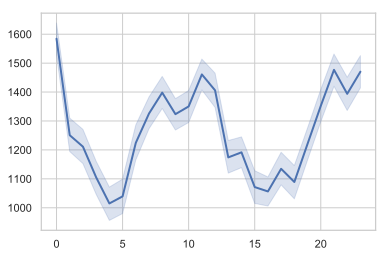

In [72]:
sns.lineplot(x=index, y=waterlist['event']-waterlist['water'])

## 乱序率变化 只要保证在较低水平就可

In [86]:
lateEvent = pd.read_csv('./adwater/20181001AW60/disorder.csv')
lateEvent.columns = ["window_end", "late_event", "all"]
lateEvent['rate'] = lateEvent['late_event']/lateEvent['all']

In [87]:
date_index = pd.date_range(start='2018-10-01 00:01:00',
                           periods=len(lateEvent), 
                           freq='T')
index = [date_index[i].hour for i in range(len(date_index))]

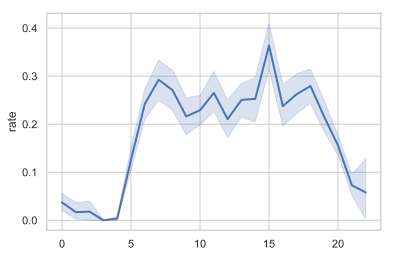

In [88]:
sns.lineplot(x=index, y=lateEvent['rate'])